# Utilizing KMeans

We will be using clustering to identify zip codes that are food insecure. 

## Use elbow method to find optimal K

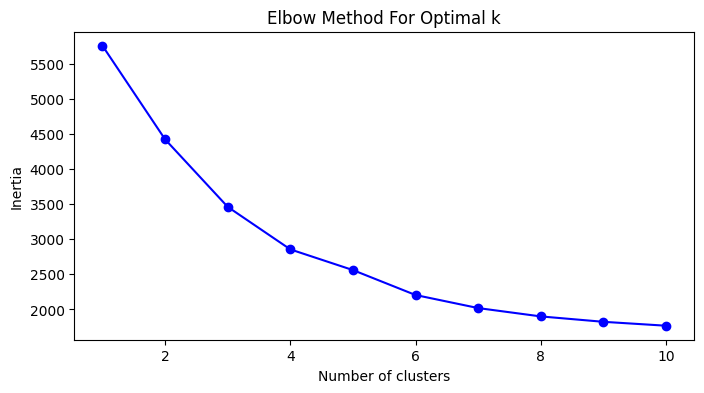

In [27]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Select the features to include in clustering
features = [
    "poverty_rate", "median_income_household", "percent_lower_education",
    "percent_higher_education", "percent_snap_participation", "per_capita_income",
    "num_food_access", "num_grocery", "num_food_pantries", "num_fast_food", "num_restaurants"
]

df_final = pd.read_csv("../data/processed/massachusetts_food_access.csv")

X = df_final[features].copy()

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

inertia = []
K = range(1, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)  # Sum of squared distances to centroids

plt.figure(figsize=(8, 4))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()

## Run KMeans

In [28]:
# Run K-Means with the chosen number of clusters (e.g., k=4)
kmeans = KMeans(n_clusters=6, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Add the cluster assignments to your original DataFrame
df_final["cluster"] = clusters

# Centroids in the scaled space
centroids_scaled = kmeans.cluster_centers_

# Inverse transform to get centroids in original feature space
centroids = scaler.inverse_transform(centroids_scaled)
centroid_df = pd.DataFrame(centroids, columns=features)

## Visualize clusters using PCA, analyze results

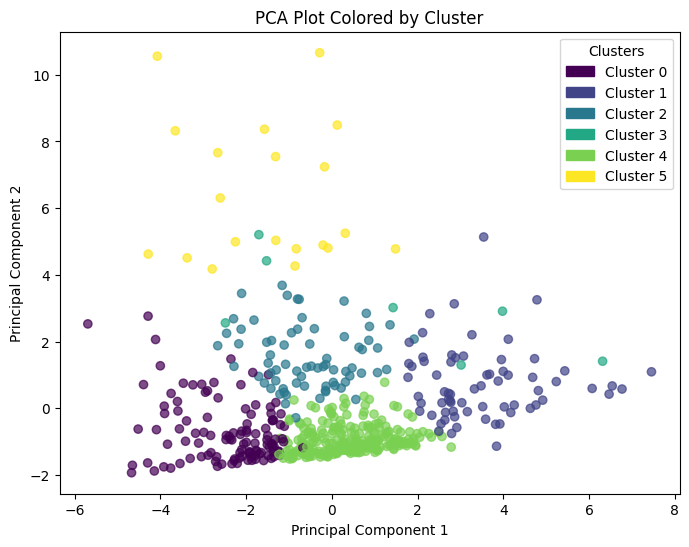

,poverty_rate,median_income_household,percent_lower_education,percent_higher_education,percent_snap_participation,per_capita_income,num_food_access,num_grocery,num_food_pantries,num_fast_food,num_restaurants
cluster,,,,,,,,,,,
0,0.049662,168454.426724,0.131273,0.868727,0.054821,88488.482759,9.612069,0.422414,0.068966,1.818966,5.379310
1,0.217604,64458.794118,0.518521,0.481479,0.316685,32389.617647,10.426471,0.823529,0.058824,3.147059,5.250000
2,0.075665,110960.492958,0.268055,0.731945,0.108160,60060.647887,26.492958,2.056338,0.211268,6.084507,14.535211
3,0.225573,97097.642857,0.373180,0.626820,0.193878,52585.428571,32.428571,0.571429,6.428571,5.142857,15.428571
4,0.071986,101896.342324,0.321283,0.678717,0.101495,51182.136929,2.925311,0.186722,0.041494,0.804979,1.319502
5,0.161314,100816.050000,0.207789,0.792211,0.131777,67776.150000,84.900000,2.800000,0.550000,18.550000,47.250000


In [29]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.decomposition import PCA
import numpy as np

# Apply PCA to reduce dimensions to 2D for visualization
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Plot the clusters in the PCA-reduced space
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', alpha=0.7)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Plot Colored by Cluster")
unique_clusters = np.unique(clusters)
handles = [mpatches.Patch(color=scatter.cmap(scatter.norm(i)), label=f'Cluster {i}') for i in unique_clusters]
plt.legend(handles=handles, title="Clusters")
plt.show()

# Display the cluster centroids
cluster_profiles = df_final.groupby("cluster")[features].mean()
display(cluster_profiles)


## Plot high need area on map

In [33]:

import folium
from folium.plugins import MarkerCluster

# Extract rows where cluster == 1
cluster1 = df_final[df_final["cluster"] == 1].copy()
cluster1["zip"] = cluster1["zip"].astype(str).str.zfill(5)

# Extract the ZIP code centroids
zip_centroids = pd.read_csv("../data/zipcodes/zip_code_database.csv")
zip_centroids["zip"] = zip_centroids["zip"].astype(str).str.zfill(5)

cluster1_coords = pd.merge(cluster1, zip_centroids, on="zip", how="left")

# Create a base map centered on Massachusetts (approximate center: Boston)
m = folium.Map(location=[42.3601, -71.0589], zoom_start=8)

# Add markers for each ZIP code in cluster 1
for _, row in cluster1_coords.iterrows():
    lat = row['latitude']
    lon = row['longitude']
    zip_code = row['zip']
    popup_text = f"Zip: {row['zip']}<br>Poverty Rate: {row['poverty_rate']:.2f}<br>Median Income: ${row['median_income_household']:.0f}"
    folium.CircleMarker(
        location=[lat, lon],
        radius=6,          
        color='red',        
        fill=True,         
        fill_color='red',  
        fill_opacity=0.8,
        popup=popup_text    
    ).add_to(m)

m